## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [2]:
import tensorflow as tf
from tensorflow import keras
import yfinance as yf

## 2. Load Stock Data

In [3]:
# Load MSFT data using yfinance library
msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="60d", interval='5m') # Last 60 days, 5 minute intervals
msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-08-17 09:30:00-04:00,290.273987,291.279999,289.970001,290.480011,1098350,0.62,0
2022-08-17 09:35:00-04:00,290.494293,291.440002,290.399994,290.820007,344495,0.00,0
2022-08-17 09:40:00-04:00,290.820007,290.899994,290.190002,290.769989,328038,0.00,0
2022-08-17 09:45:00-04:00,290.799988,291.700012,290.799988,291.410004,324364,0.00,0
2022-08-17 09:50:00-04:00,291.369995,291.820007,290.839996,291.690002,328764,0.00,0


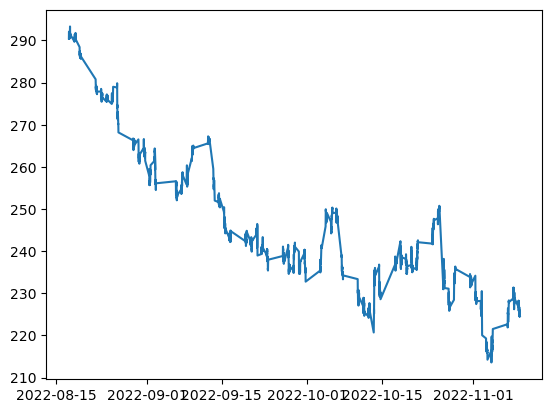

In [4]:
# Visualize MSFT stock data
plt.plot(msft_hist.index, msft_hist['Close'])

In [5]:
df_msft = msft_hist.reset_index()['Close']
df_msft.head()

0    290.480011
1    290.820007
2    290.769989
3    291.410004
4    291.690002
Name: Close, dtype: float64

In [6]:
# Load AAPL data using yfinance library
aapl = yf.Ticker("AAPL")
aapl_hist = aapl.history(period="60d", interval='5m') # Last 60 days, 5 minute intervals
aapl_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-08-17 09:30:00-04:00,173.250000,173.630005,173.009995,173.169998,4569900,0.0,0
2022-08-17 09:35:00-04:00,173.169998,174.130005,173.102005,173.589996,2075670,0.0,0
2022-08-17 09:40:00-04:00,173.570007,173.639999,173.149994,173.570007,1464049,0.0,0
2022-08-17 09:45:00-04:00,173.570007,174.059998,173.529999,174.029099,1355095,0.0,0
2022-08-17 09:50:00-04:00,174.029999,174.149994,173.649994,174.000000,1211123,0.0,0


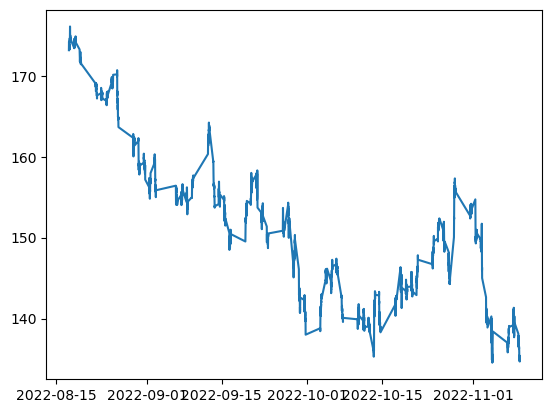

In [7]:
# Visualize AAPL stock prices
plt.plot(aapl_hist.index, aapl_hist['Close'])

In [8]:
df_aapl = aapl_hist.reset_index()['Close']
df_aapl.head()

0    173.169998
1    173.589996
2    173.570007
3    174.029099
4    174.000000
Name: Close, dtype: float64

## 3. Perform Data Preprocessing

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler_msft = MinMaxScaler(feature_range=(0,1))
df1_msft = scaler_msft.fit_transform(np.array(df_msft).reshape(-1, 1))

scaler_aapl = MinMaxScaler(feature_range=(0,1))
df1_aapl = scaler_aapl.fit_transform(np.array(df_aapl).reshape(-1, 1))

In [10]:
# Split into training, validation, and testing sets
train_size = int(len(df1_msft)*0.65)
val_size = int(len(df1_msft)*0.15)
test_size = len(df1_msft) - train_size - val_size
train_data_msft, val_data_msft, test_data_msft = df1_msft[0:train_size, :], df1_msft[train_size:train_size+val_size, :], df1_msft[train_size+val_size:len(df1_msft), :]
train_data_aapl, val_data_aapl, test_data_aapl = df1_aapl[0:train_size, :], df1_aapl[train_size:train_size+val_size, :], df1_aapl[train_size+val_size:len(df1_aapl), :]

In [11]:
def create_dataset(dataset, time_step=1):
    '''
    Split data into timesteps of length 60 (data from last 5 hours)
    '''
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
# Create data for MSFT
time_step = 60
X_train_msft, y_train_msft = create_dataset(train_data_msft, time_step)
X_val_msft, y_val_msft = create_dataset(val_data_msft, time_step)
X_test_msft, y_test_msft = create_dataset(test_data_msft, time_step)

In [13]:
# Create data for AAPL
time_step = 60
X_train_aapl, y_train_aapl = create_dataset(train_data_aapl, time_step)
X_val_aapl, y_val_aapl = create_dataset(val_data_aapl, time_step)
X_test_aapl, y_test_aapl = create_dataset(test_data_aapl, time_step)

## Train Model

### Approach 1: Train model twice
Train on AAPL first, then train on MSFT, then make predictions

In [14]:
# Create model
model = tf.keras.Sequential((
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(60,1)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1))
)
model.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
# Train model on AAPL data
history_aapl = model.fit(
    X_train_aapl,
    y_train_aapl,
    batch_size=16,
    epochs=40,
    validation_data=(X_val_aapl, y_val_aapl),
)

Epoch 1/40
187/187 [==============================] - 12s 48ms/step - loss: 0.0052 - val_loss: 4.6399e-04
Epoch 2/40
187/187 [==============================] - 5s 27ms/step - loss: 4.0958e-04 - val_loss: 4.2827e-04
Epoch 3/40
187/187 [==============================] - 5s 28ms/step - loss: 4.0357e-04 - val_loss: 3.8145e-04
Epoch 4/40
187/187 [==============================] - 5s 27ms/step - loss: 3.3939e-04 - val_loss: 3.4744e-04
Epoch 5/40
187/187 [==============================] - 7s 37ms/step - loss: 3.3963e-04 - val_loss: 3.9851e-04
Epoch 6/40
187/187 [==============================] - 7s 36ms/step - loss: 3.1114e-04 - val_loss: 2.9999e-04
Epoch 7/40
187/187 [==============================] - 7s 36ms/step - loss: 2.6335e-04 - val_loss: 3.7648e-04
Epoch 8/40
187/187 [==============================] - 7s 37ms/step - loss: 2.5452e-04 - val_loss: 3.2128e-04
Epoch 9/40
187/187 [==============================] - 7s 37ms/step - loss: 2.5519e-04 - val_loss: 2.5354e-04
Epoch 10/40
187/187 [=

In [16]:
# Train model on MSFT data
history_msft = model.fit(
    X_train_msft,
    y_train_msft,
    batch_size=16,
    epochs=40,
    validation_data=(X_val_msft, y_val_msft),
)

Epoch 1/40
187/187 [==============================] - 7s 38ms/step - loss: 6.1121e-05 - val_loss: 7.2376e-05
Epoch 2/40
187/187 [==============================] - 7s 35ms/step - loss: 5.8399e-05 - val_loss: 1.0739e-04
Epoch 3/40
187/187 [==============================] - 7s 35ms/step - loss: 5.5115e-05 - val_loss: 6.8398e-05
Epoch 4/40
187/187 [==============================] - 8s 42ms/step - loss: 8.0020e-05 - val_loss: 1.1570e-04
Epoch 5/40
187/187 [==============================] - 8s 41ms/step - loss: 5.7335e-05 - val_loss: 8.0169e-05
Epoch 6/40
187/187 [==============================] - 7s 40ms/step - loss: 5.1609e-05 - val_loss: 6.7068e-05
Epoch 7/40
187/187 [==============================] - 6s 34ms/step - loss: 5.8098e-05 - val_loss: 8.9038e-05
Epoch 8/40
187/187 [==============================] - 6s 34ms/step - loss: 5.6235e-05 - val_loss: 6.7421e-05
Epoch 9/40
187/187 [==============================] - 6s 34ms/step - loss: 5.5302e-05 - val_loss: 6.7071e-05
Epoch 10/40
187/187

In [17]:
# Make predictions
y_preds_aapl = scaler_aapl.inverse_transform(model.predict(X_test_aapl))
y_preds_msft = scaler_msft.inverse_transform(model.predict(X_test_msft))

In [18]:
# Calculate RMSE
rmse_aapl = math.sqrt(mean_squared_error(scaler_aapl.inverse_transform(y_test_aapl.reshape(-1, 1)),y_preds_aapl))
rmse_msft = math.sqrt(mean_squared_error(scaler_msft.inverse_transform(y_test_msft.reshape(-1, 1)),y_preds_msft))
print('RMSE on AAPL: {}'.format(rmse_aapl))
print('RMSE on MSFT: {}'.format(rmse_msft))

RMSE on AAPL: 0.4298508581296078
RMSE on MSFT: 0.828200714485089


Text(0.5, 1.0, 'AAPL Stock Price Predictions')

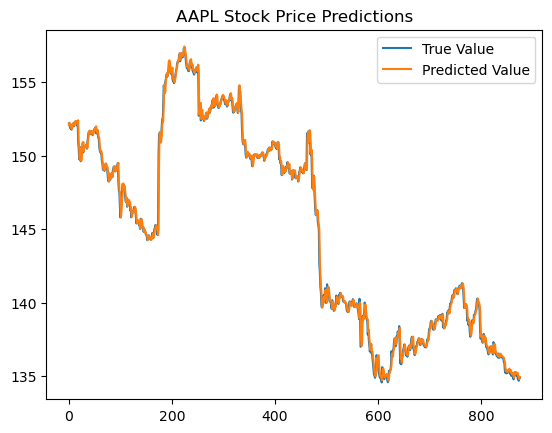

In [19]:
# Plot AAPL predictions
plt.plot(scaler_aapl.inverse_transform(y_test_aapl.reshape(-1, 1)), label='True Value')
plt.plot(y_preds_aapl, label='Predicted Value')
plt.legend()
plt.title('AAPL Stock Price Predictions')

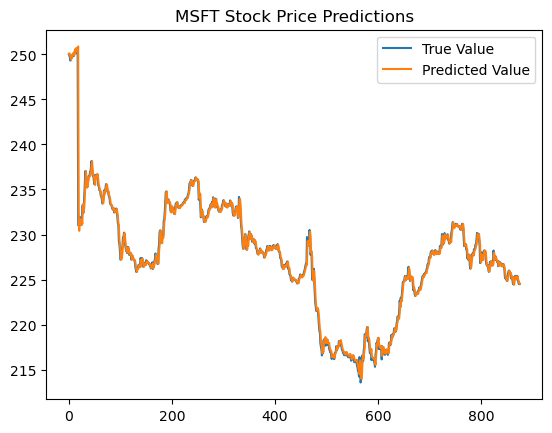

In [20]:
# Plot MSFT predictions
plt.plot(scaler_msft.inverse_transform(y_test_msft.reshape(-1, 1)), label='True Value')
plt.plot(y_preds_msft, label='Predicted Value')
plt.title('MSFT Stock Price Predictions')
plt.legend()

In [21]:
# Save model
model.save('Models/model_1')

INFO:tensorflow:Assets written to: Models/model_1\assets


INFO:tensorflow:Assets written to: Models/model_1\assets


### Approach 2: Train on both stocks at once

In [22]:
# Create model
model_combined = tf.keras.Sequential((
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(60,1)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1))
)
model_combined.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
# Train model
history = model_combined.fit(
    np.concatenate((X_train_aapl, X_train_msft)),
    np.concatenate((y_train_aapl, y_train_msft)),
    batch_size=16,
    epochs=40,
    validation_data=(np.concatenate((X_val_aapl, X_val_msft)), np.concatenate((y_val_aapl, y_val_msft))),
)

Epoch 1/40
373/373 [==============================] - 22s 53ms/step - loss: 0.0043 - val_loss: 6.1052e-04
Epoch 2/40
373/373 [==============================] - 18s 47ms/step - loss: 3.3365e-04 - val_loss: 4.3227e-04
Epoch 3/40
373/373 [==============================] - 21s 56ms/step - loss: 2.8795e-04 - val_loss: 2.9921e-04
Epoch 4/40
373/373 [==============================] - 22s 59ms/step - loss: 2.5001e-04 - val_loss: 2.6458e-04
Epoch 5/40
373/373 [==============================] - 20s 53ms/step - loss: 2.3573e-04 - val_loss: 2.3431e-04
Epoch 6/40
373/373 [==============================] - 18s 49ms/step - loss: 1.9121e-04 - val_loss: 2.1133e-04
Epoch 7/40
373/373 [==============================] - 21s 57ms/step - loss: 1.5756e-04 - val_loss: 1.7501e-04
Epoch 8/40
373/373 [==============================] - 16s 42ms/step - loss: 1.4576e-04 - val_loss: 1.5904e-04
Epoch 9/40
373/373 [==============================] - 13s 34ms/step - loss: 1.2815e-04 - val_loss: 1.4952e-04
Epoch 10/40
37

In [24]:
# Make predictions
y_preds_aapl_comb = scaler_aapl.inverse_transform(model.predict(X_test_aapl))
y_preds_msft_comb = scaler_msft.inverse_transform(model.predict(X_test_msft))

In [25]:
# Calculate RMSE
rmse_aapl_comb = math.sqrt(mean_squared_error(scaler_aapl.inverse_transform(y_test_aapl.reshape(-1, 1)),y_preds_aapl_comb))
rmse_msft_comb = math.sqrt(mean_squared_error(scaler_msft.inverse_transform(y_test_msft.reshape(-1, 1)),y_preds_msft_comb))
print('RMSE on AAPL: {}'.format(rmse_aapl_comb))
print('RMSE on MSFT: {}'.format(rmse_msft_comb))

RMSE on AAPL: 0.4298508581296078
RMSE on MSFT: 0.828200714485089


Text(0.5, 1.0, 'AAPL Stock Price Predictions')

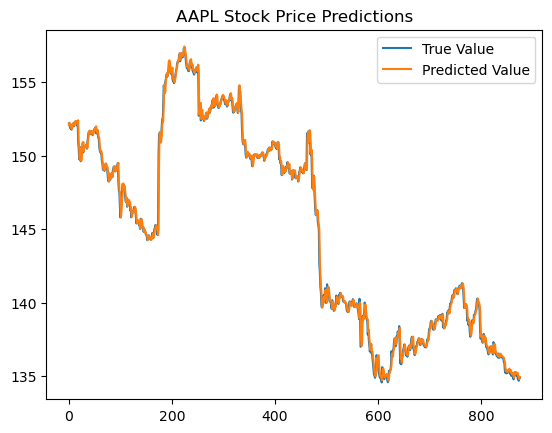

In [26]:
# Plot AAPL predictions
plt.plot(scaler_aapl.inverse_transform(y_test_aapl.reshape(-1, 1)), label='True Value')
plt.plot(y_preds_aapl_comb, label='Predicted Value')
plt.legend()
plt.title('AAPL Stock Price Predictions')

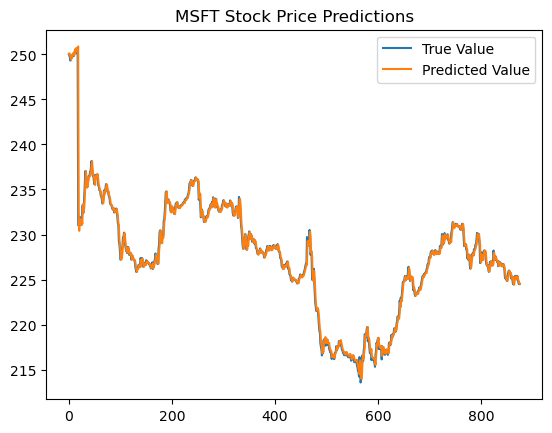

In [27]:
# Plot MSFT predictions
plt.plot(scaler_msft.inverse_transform(y_test_msft.reshape(-1, 1)), label='True Value')
plt.plot(y_preds_msft_comb, label='Predicted Value')
plt.title('MSFT Stock Price Predictions')
plt.legend()

In [28]:
# Save model
model_combined.save('Models/model_combined_1')

INFO:tensorflow:Assets written to: Models/model_combined_1\assets


INFO:tensorflow:Assets written to: Models/model_combined_1\assets
